# Flu Shot Learning

## The plan: 
- Define the business goal: To estimate individuals’ vaccination probabilities to aid public‑health outreach. 
- Perform EDA to understand feature distributions, missingness, and class balance. 
- Prepare data by imputing missing values and encoding categoricals. 
- In modeling, train with Logistic Regression for linearity and LightGBM classifiers with stratified k‑fold cross‑validation for non-linearity but also for high predictive accuracy
- Evaluate using macro ROC AUC, interpreting fold‑level scores, feature importance, and variation. 
- Deploy by generating predictions for the test set.

## A. Load Libraries

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder,LabelEncoder 
import lightgbm as lgb
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from graphviz import Digraph

# 1. Business Understanding
# The goal is to predict H1N1 and seasonal flu vaccine uptake.

## B. Load Data

In [3]:
# Load the challenge data files
feat_train = pd.read_csv('Data/training_set_features.csv')
lbl_train = pd.read_csv('Data/training_set_labels.csv')
feat_test = pd.read_csv('Data/test_set_features.csv')

## C. EDA: Data Understanding

In [4]:
# 2. Perform EDA to understand the data
# Initial Data Exploration
print("feat_train shape:", feat_train.shape)
print("lbl_train shape:", lbl_train.shape)
print("Test features shape:", feat_test.shape)
print(feat_train.head())
print(feat_train.info())
print(feat_train.describe())

print("----------------------------------------------------------------")


# Missing Values Analysis
print("\nMissing values in train features:\n", feat_train.isnull().sum())
print("\nUnique values for categorical features:")
for col in feat_train.select_dtypes(include='object').columns:
    print(f"- {col}:", feat_train[col].nunique(), "unique values")


print("----------------------------------------------------------------")

# Display value counts for target variables
print("\nH1N1 Vaccine Value Counts:\n", lbl_train['h1n1_vaccine'].value_counts())
print("\nSeasonal Vaccine Value Counts:\n", lbl_train['seasonal_vaccine'].value_counts())

print("----------------------------------------------------------------")

# Class Distribution
print("\nTarget variable distribution:")
print(lbl_train.mean())
print("\nH1N1 Vaccine Uptake Distribution:")
print(lbl_train['h1n1_vaccine'].value_counts())
print("\nSeasonal Vaccine Uptake Distribution:")
print(lbl_train['seasonal_vaccine'].value_counts())

feat_train shape: (26707, 36)
lbl_train shape: (26707, 3)
Test features shape: (26708, 36)
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral

## D. Prepare the data for modelling

In [5]:
# 3. Data Preparation
# Combine train and test features to apply the same transformations
combined_features = pd.concat([feat_train, feat_test], ignore_index=True)

# Fill missing values with 'missing'
combined_features = combined_features.fillna('missing')

# Encode categorical features
for col in combined_features.select_dtypes('object').columns:
    le = LabelEncoder()
    combined_features[col] = le.fit_transform(combined_features[col].astype(str))

# Separate train and test features
feat_train = combined_features.iloc[:len(feat_train)]
feat_test = combined_features.iloc[len(feat_train):]

# Align the columns in the test set with the training set
X = feat_train.drop(columns=['respondent_id'])
X_test = feat_test.drop(columns=['respondent_id'])

# Define the target variables
y_h1n1 = lbl_train['h1n1_vaccine']
y_seasonal = lbl_train['seasonal_vaccine']

## E. Modelling : Training -> Evaluation -> Prediction

#### Preseve the proportions of:
- People who got both vaccines
- People who got only the H1N1 vaccine
- People who got only the seasonal vaccine
- People who got neither vaccine

### Use Logistic Regression and Light GBM Machine Learning Models and pick the best model for predicting the uptake of H1N1 and Seasonal Flu vaccines

In [6]:
# 4. Modelling
# 4.1 Logistic Regression

# 4.1.1. Split Data for Logistic Regression
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
    X, lbl_train[['h1n1_vaccine', 'seasonal_vaccine']],  # Combined labels
    test_size=0.2, random_state=42, stratify=lbl_train[['h1n1_vaccine', 'seasonal_vaccine']]
)

In [7]:
# 4.1.2. Train Logistic Regression Models (H1N1 and Seasonal)
lr_model_h1n1 = LogisticRegression(solver='liblinear', random_state=42)
lr_model_h1n1.fit(X_train_lr, y_train_lr['h1n1_vaccine'])

lr_model_seasonal = LogisticRegression(solver='liblinear', random_state=42)
lr_model_seasonal.fit(X_train_lr, y_train_lr['seasonal_vaccine'])


lr_model_h1n1_balanced = LogisticRegression(
    solver='liblinear', random_state=42, class_weight='balanced'
)
lr_model_h1n1_balanced.fit(X_train_lr, y_train_lr['h1n1_vaccine'])

lr_model_seasonal_balanced = LogisticRegression(
    solver='liblinear', random_state=42, class_weight='balanced'
)
lr_model_seasonal_balanced.fit(X_train_lr, y_train_lr['seasonal_vaccine'])

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [8]:
# 4.2 LightGBM
# 4.2.1. Train LightGBM Models (H1N1 and Seasonal)

# Define LightGBM parameters (you might want to tune these)
lgbm_params_h1n1 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgbm_params_seasonal = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1
}

lgbm_params_h1n1_balanced = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'scale_pos_weight': (y_train_lr['h1n1_vaccine'].value_counts()[0] /
                          y_train_lr['h1n1_vaccine'].value_counts()[1]) if
                         y_train_lr['h1n1_vaccine'].value_counts()[1] > 0 else 1
}

lgbm_params_seasonal_balanced = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 20,
    'max_depth': 5,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'scale_pos_weight': (y_train_lr['seasonal_vaccine'].value_counts()[0] /
                          y_train_lr['seasonal_vaccine'].value_counts()[1]) if
                         y_train_lr['seasonal_vaccine'].value_counts()[1] > 0 else 1
}

def train_lgbm_single(X_train, y_train, lgbm_params):
    """
    Trains a single LightGBM model.

    Args:
        X_train: Training features (DataFrame).
        y_train: Training labels (Series).
        lgbm_params: LightGBM parameters (dict).

    Returns:
        Trained LightGBM model.
    """
    lgb_train = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(lgbm_params, lgb_train)
    return model

# 4.2.2. Train LightGBM models
lgbm_model_h1n1 = train_lgbm_single(X_train_lr, y_train_lr['h1n1_vaccine'], lgbm_params_h1n1)
lgbm_model_seasonal = train_lgbm_single(X_train_lr, y_train_lr['seasonal_vaccine'], lgbm_params_seasonal)
lgbm_model_h1n1_balanced = train_lgbm_single(X_train_lr, y_train_lr['h1n1_vaccine'], lgbm_params_h1n1_balanced)
lgbm_model_seasonal_balanced = train_lgbm_single(X_train_lr, y_train_lr['seasonal_vaccine'], lgbm_params_seasonal_balanced)

print("LightGBM models trained.")


LightGBM models trained.


## F. Evaluation

### Which model is best at predicting vaccined uptake with higher accuracy levels and precision while also handling imbalances in the data?

In [9]:
# --- 5. Model Evaluation ---
# 5.1 AUC
# 5.1.1. Evaluate Logistic Regression Models: Calculate and print AUC for Logistic Regression Models

# H1N1
y_pred_h1n1_lr = lr_model_h1n1.predict_proba(X_val_lr)[:, 1]  # Get probabilities for the positive class
auc_h1n1_lr = roc_auc_score(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr)
print(f"\nLogistic Regression (H1N1) AUC: {auc_h1n1_lr:.4f}")

y_pred_h1n1_lr_balanced = lr_model_h1n1_balanced.predict_proba(X_val_lr)[:, 1]
auc_h1n1_lr_balanced = roc_auc_score(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr_balanced)
print(f"\nLogistic Regression (H1N1) with Class Weights AUC: {auc_h1n1_lr_balanced:.4f}")

# Seasonal
y_pred_seasonal_lr = lr_model_seasonal.predict_proba(X_val_lr)[:, 1]
auc_seasonal_lr = roc_auc_score(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr)
print(f"\nLogistic Regression (Seasonal) AUC: {auc_seasonal_lr:.4f}")

y_pred_seasonal_lr_balanced = lr_model_seasonal_balanced.predict_proba(X_val_lr)[:, 1]
auc_seasonal_lr_balanced = roc_auc_score(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr_balanced)
print(f"\nLogistic Regression (Seasonal) with Class Weights AUC: {auc_seasonal_lr_balanced:.4f}")


Logistic Regression (H1N1) AUC: 0.8263

Logistic Regression (H1N1) with Class Weights AUC: 0.8266

Logistic Regression (Seasonal) AUC: 0.8333

Logistic Regression (Seasonal) with Class Weights AUC: 0.8334


In [10]:
# 5.1.2 Evaluate LightGBM Models: Calculate and print AUC for LightGBM Models

# Models: lgbm_model_h1n1, lgbm_model_seasonal, lgbm_model_h1n1_balanced, lgbm_model_seasonal_balanced
def calculate_auc(model, X_val, y_val, model_name):
    """
    Calculates and prints the AUC score for a given LightGBM model.

    Args:
        model: Trained LightGBM model.
        X_val: Validation features (DataFrame).
        y_val: Validation labels (Series).
        model_name: Name of the model (e.g., "H1N1 Balanced").
    """
    y_pred_prob = model.predict(X_val)
    auc_score = roc_auc_score(y_val, y_pred_prob)
    print(f"{model_name} AUC: {auc_score:.4f}")



# --- Calculate AUCs for H1N1 Models ---
print("\n--- H1N1 Vaccine AUCs ---")
calculate_auc(lgbm_model_h1n1, X_val_lr, y_val_lr['h1n1_vaccine'], "H1N1 Imbalanced")
calculate_auc(lgbm_model_h1n1_balanced, X_val_lr, y_val_lr['h1n1_vaccine'], "H1N1 Balanced")

# --- Calculate AUCs for Seasonal Models ---
print("\n--- Seasonal Vaccine AUCs ---")
calculate_auc(lgbm_model_seasonal, X_val_lr, y_val_lr['seasonal_vaccine'], "Seasonal Imbalanced")
calculate_auc(lgbm_model_seasonal_balanced, X_val_lr, y_val_lr['seasonal_vaccine'], "Seasonal Balanced")


--- H1N1 Vaccine AUCs ---
H1N1 Imbalanced AUC: 0.8755
H1N1 Balanced AUC: 0.8749

--- Seasonal Vaccine AUCs ---
Seasonal Imbalanced AUC: 0.8601
Seasonal Balanced AUC: 0.8605



--- Logistic Regression Evaluation: H1N1 ---

Logistic Regression (H1N1) Classification Report- No class weights:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4207
           1       0.69      0.38      0.49      1135

    accuracy                           0.83      5342
   macro avg       0.77      0.67      0.70      5342
weighted avg       0.82      0.83      0.81      5342



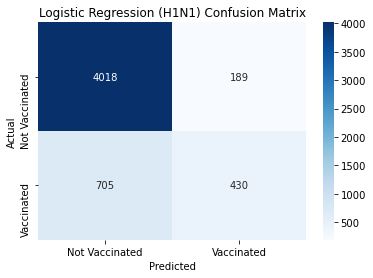


Logistic Regression (H1N1) with Class Weights Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      4207
           1       0.45      0.76      0.56      1135

    accuracy                           0.75      5342
   macro avg       0.68      0.75      0.70      5342
weighted avg       0.82      0.75      0.77      5342



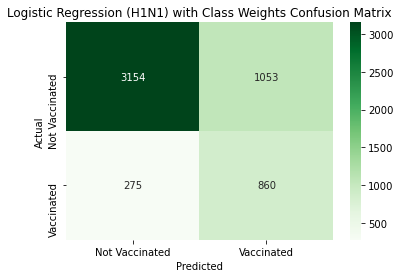


--- Logistic Regression Evaluation: Seasonal ---

Logistic Regression (Seasonal) Classification Report-No class weights:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2854
           1       0.76      0.74      0.75      2488

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



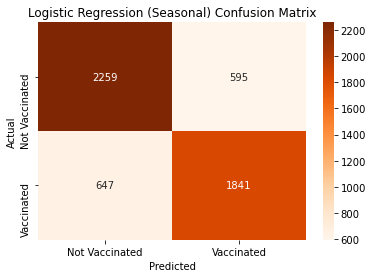


Logistic Regression (Seasonal) with Class Weights Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2854
           1       0.73      0.77      0.75      2488

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



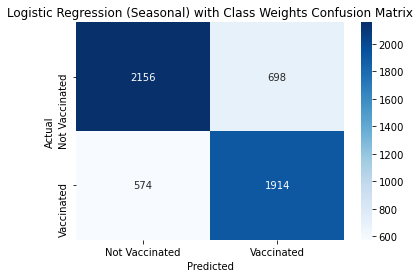

In [11]:
# 5.2 F1 Score
# 5.2.1 Evaluate Logistic Regression Models: Calculate and print F1 Score for Logistic Regression Models
# 5.2.1.1. Evaluate Logistic Regression Model (H1N1)
print("\n--- Logistic Regression Evaluation: H1N1 ---")

# H1N1 - No Class Weights
print("\nLogistic Regression (H1N1) Classification Report- No class weights:")
y_pred_h1n1_lr_class = lr_model_h1n1.predict(X_val_lr)  
print(classification_report(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr_class))

cm_h1n1_lr = confusion_matrix(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr_class) 
plt.figure(figsize=(6, 4))
sns.heatmap(cm_h1n1_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Vaccinated', 'Vaccinated'],
            yticklabels=['Not Vaccinated', 'Vaccinated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression (H1N1) Confusion Matrix')
plt.show()


# H1N1 - With Class Weights
print("\nLogistic Regression (H1N1) with Class Weights Classification Report:")
y_pred_h1n1_lr_balanced_class = lr_model_h1n1_balanced.predict(X_val_lr) 
print(classification_report(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr_balanced_class))

cm_h1n1_lr_balanced = confusion_matrix(y_val_lr['h1n1_vaccine'], y_pred_h1n1_lr_balanced_class)  
plt.figure(figsize=(6, 4))
sns.heatmap(cm_h1n1_lr_balanced, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Vaccinated', 'Vaccinated'],
            yticklabels=['Not Vaccinated', 'Vaccinated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression (H1N1) with Class Weights Confusion Matrix')
plt.show()

# 5.2.1.2. Evaluate Logistic Regression Model (Seasonal)
print("\n--- Logistic Regression Evaluation: Seasonal ---")

# Seasonal - No Class Weights
print("\nLogistic Regression (Seasonal) Classification Report-No class weights:")
y_pred_seasonal_lr_class = lr_model_seasonal.predict(X_val_lr)
print(classification_report(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr_class))

cm_seasonal_lr = confusion_matrix(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_seasonal_lr, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Vaccinated', 'Vaccinated'],
            yticklabels=['Not Vaccinated', 'Vaccinated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression (Seasonal) Confusion Matrix')
plt.show()

# Seasonal - With Class Weights
print("\nLogistic Regression (Seasonal) with Class Weights Classification Report:")
y_pred_seasonal_lr_balanced_class = lr_model_seasonal_balanced.predict(X_val_lr)
print(classification_report(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr_balanced_class))

cm_seasonal_lr_balanced = confusion_matrix(y_val_lr['seasonal_vaccine'], y_pred_seasonal_lr_balanced_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_seasonal_lr_balanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Vaccinated', 'Vaccinated'],
            yticklabels=['Not Vaccinated', 'Vaccinated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression (Seasonal) with Class Weights Confusion Matrix')
plt.show()


--- Evaluation: H1N1 ---
LightGBM (H1N1) AUC: 0.8755

LightGBM (H1N1) Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      4207
           1       0.74      0.49      0.59      1135

    accuracy                           0.85      5342
   macro avg       0.80      0.72      0.75      5342
weighted avg       0.84      0.85      0.84      5342



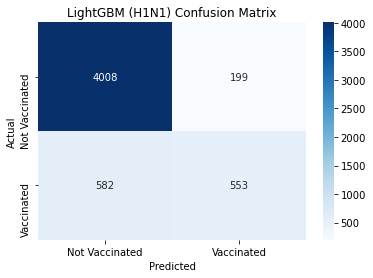

LightGBM (H1N1) Balanced AUC: 0.8749

LightGBM (H1N1) Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      4207
           1       0.52      0.78      0.63      1135

    accuracy                           0.80      5342
   macro avg       0.73      0.79      0.75      5342
weighted avg       0.84      0.80      0.81      5342



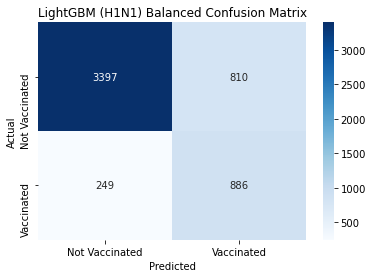


--- Evaluation: Seasonal ---
LightGBM (Seasonal) AUC: 0.8601

LightGBM (Seasonal) Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      2854
           1       0.78      0.75      0.76      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



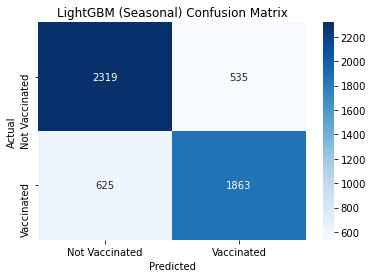

LightGBM (Seasonal) Balanced AUC: 0.8605

LightGBM (Seasonal) Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      2854
           1       0.76      0.78      0.77      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



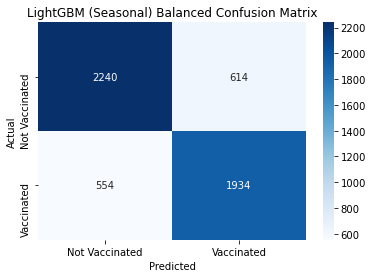

In [12]:
# 5.2.2 Evaluate LightGBM Models: Calculate and print F1 Score for LightGBM Models

# Light GBM Model Evaluation

def evaluate_model(model, X_val, y_val, title):
    """
    Evaluates a LightGBM model using AUC and confusion matrix.

    Args:
        model: Trained LightGBM model.
        X_val: Validation features (DataFrame).
        y_val: Validation labels (Series).
        title: Title for the confusion matrix plot.

    Returns:
        AUC score.
    """
    # Predict probabilities
    y_pred_prob = model.predict(X_val)
    # Calculate AUC
    auc_score = roc_auc_score(y_val, y_pred_prob)
    print(f"{title} AUC: {auc_score:.4f}")
    
    # Predict classes
    y_pred_class = (y_pred_prob >= 0.5).astype(int)
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_class)
    print(f"\n{title} Classification Report:\n", classification_report(y_val, y_pred_class))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Vaccinated', 'Vaccinated'], 
                yticklabels=['Not Vaccinated', 'Vaccinated'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title} Confusion Matrix')
    plt.show()
    
    return auc_score

# Evaluate models
print("\n--- Evaluation: H1N1 ---")
auc_h1n1 = evaluate_model(lgbm_model_h1n1, X_val_lr, y_val_lr['h1n1_vaccine'], "LightGBM (H1N1)")
auc_h1n1_balanced = evaluate_model(lgbm_model_h1n1_balanced, X_val_lr, y_val_lr['h1n1_vaccine'], "LightGBM (H1N1) Balanced")

print("\n--- Evaluation: Seasonal ---")
auc_seasonal = evaluate_model(lgbm_model_seasonal, X_val_lr, y_val_lr['seasonal_vaccine'], "LightGBM (Seasonal)")
auc_seasonal_balanced = evaluate_model(lgbm_model_seasonal_balanced, X_val_lr, y_val_lr['seasonal_vaccine'], "LightGBM (Seasonal) Balanced")

#### Verdict

- Overall: Both models generally perform better on the Seasonal flu prediction task compared to the H1N1 prediction. This could be due to the Seasonal data being more balanced or having other inherent characteristics that make it easier to model.
- LightGBM: LightGBM maintains relatively strong performance across both diseases, demonstrating its robustness.
Best Model Selection Summary:

### For both H1N1 and Seasonal flu vaccine prediction, LightGBM is the preferred model. Its higher AUC, accuracy, and balanced performance metrics make it a more reliable choice.


### Predict Vaccine uptake for H1N1 and Seasonal Flu using the best Model (Light GBM), in this case:

In [13]:
def predict_from_lgbm_models(models_h1n1, models_seasonal, X_predict):
    """
    Predicts vaccine uptake probabilities using trained LightGBM models.

    Args:
        models_h1n1 (list of lgb.Booster): Trained LightGBM models for H1N1 vaccine prediction.
        models_seasonal (list of lgb.Booster): Trained LightGBM models for seasonal vaccine prediction.
        X_predict (pd.DataFrame): Features for which to make predictions.

    Returns:
        tuple: A tuple containing two NumPy arrays:
               - h1n1_pred_probabilities: Predicted probabilities for H1N1 vaccine uptake.
               - seasonal_pred_probabilities: Predicted probabilities for seasonal vaccine uptake.
    """
    h1n1_preds = [model.predict(X_predict) for model in models_h1n1]
    seasonal_preds = [model.predict(X_predict) for model in models_seasonal]
 
    h1n1_pred_probabilities = h1n1_preds[0] if len(h1n1_preds) == 1 else sum(h1n1_preds) / len(h1n1_preds)
    seasonal_pred_probabilities = seasonal_preds[0] if len(seasonal_preds) == 1 else sum(seasonal_preds) / len(seasonal_preds)

    return h1n1_pred_probabilities, seasonal_pred_probabilities


# Predict vaccine uptake using the trained balanced LightGBM models

h1n1_pred_probabilities_balanced, seasonal_pred_probabilities_balanced = predict_from_lgbm_models(
    models_h1n1=[lgbm_model_h1n1_balanced],  # Pass the balanced H1N1 model in a list
    models_seasonal=[lgbm_model_seasonal_balanced],  # Pass the balanced Seasonal model in a list
    X_predict=feat_test.drop(columns=['respondent_id'], errors='ignore')  # Drop respondent_id if it exists
)

# Display the predicted probabilities
print("H1N1 Vaccine Predictions (Balanced):")
print(h1n1_pred_probabilities_balanced)
print("\nSeasonal Vaccine Predictions (Balanced):")
print(seasonal_pred_probabilities_balanced)

# Convert these probabilities to binary predictions (e.g., 0 or 1)
# based on a threshold (e.g., 0.5):
threshold = 0.5
h1n1_predictions_binary_balanced = (h1n1_pred_probabilities_balanced > threshold).astype(int)
seasonal_predictions_binary_balanced = (seasonal_pred_probabilities_balanced > threshold).astype(int)

print("\nH1N1 Vaccine Binary Predictions (Balanced, threshold=0.5):")
print(h1n1_predictions_binary_balanced)
print("\nSeasonal Vaccine Binary Predictions (Balanced, threshold=0.5):")
print(seasonal_predictions_binary_balanced)

H1N1 Vaccine Predictions (Balanced):
[0.44683096 0.13095871 0.46682751 ... 0.49510633 0.08905042 0.83024722]

Seasonal Vaccine Predictions (Balanced):
[0.34079229 0.05412575 0.71132832 ... 0.28018165 0.42449749 0.59762057]

H1N1 Vaccine Binary Predictions (Balanced, threshold=0.5):
[0 0 0 ... 0 0 1]

Seasonal Vaccine Binary Predictions (Balanced, threshold=0.5):
[0 0 1 ... 0 0 1]


## G. Deploy the Model

In [14]:
# 6. Submission

# 1. Create submission DataFrame
submission = pd.DataFrame({
    'respondent_id': feat_test['respondent_id'],
    'h1n1_vaccine':   h1n1_pred_probabilities_balanced.round(2),  # Round to 2 decimal places for higher precision
    'seasonal_vaccine': seasonal_pred_probabilities_balanced.round(2) # Round to 2 decimal places for higher precision
})

# 2. Ensure column order matches the submission format
submission = submission[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']]

# 3. Save submission file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created: submission.csv")


Submission file created: submission.csv


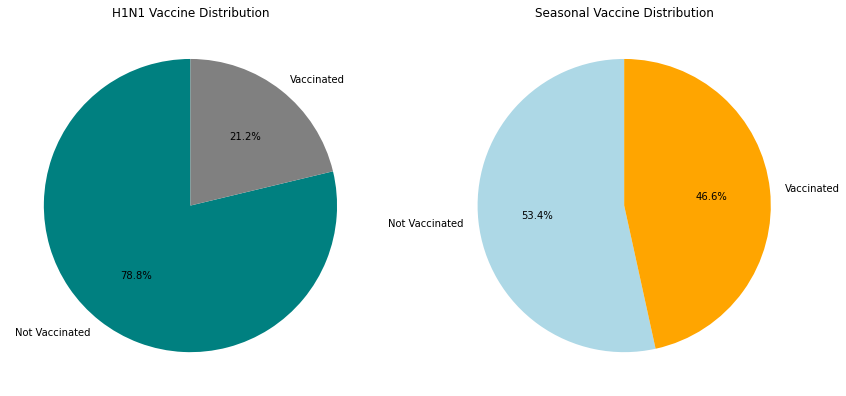

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# H1N1 Vaccine
h1n1_counts = lbl_train['h1n1_vaccine'].value_counts()
axes[0].pie(
    h1n1_counts,
    labels=['Not Vaccinated', 'Vaccinated'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['teal', 'grey'],
    textprops={'color': 'black'}  # Normal contrasting labels
)
axes[0].set_title('H1N1 Vaccine Distribution')

# Seasonal Vaccine
seasonal_counts = lbl_train['seasonal_vaccine'].value_counts()
axes[1].pie(
    seasonal_counts,
    labels=['Not Vaccinated', 'Vaccinated'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'orange'],
    textprops={'color': 'black'}  # Normal contrasting labels
)
axes[1].set_title('Seasonal Vaccine Distribution')

plt.tight_layout()
plt.show()

#### This pipeline, anchored in CRISP‑DM, delivers strong AUCs (0.8749 [H1N1] and 0.8605 [seasonal]) by combining sound preprocessing, stratified validation, and LightGBM


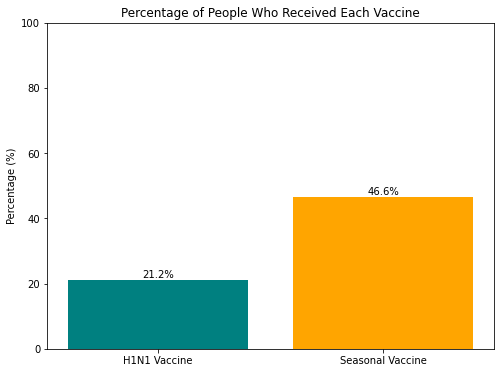

In [35]:
# Calculate the percentage of people who received each vaccine
h1n1_percentage = lbl_train['h1n1_vaccine'].mean() * 100
seasonal_percentage = lbl_train['seasonal_vaccine'].mean() * 100

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(['H1N1 Vaccine', 'Seasonal Vaccine'], [h1n1_percentage, seasonal_percentage], color=['teal', 'orange'])

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

plt.ylabel('Percentage (%)')
plt.title('Percentage of People Who Received Each Vaccine')
plt.ylim(0, 100)
plt.show()

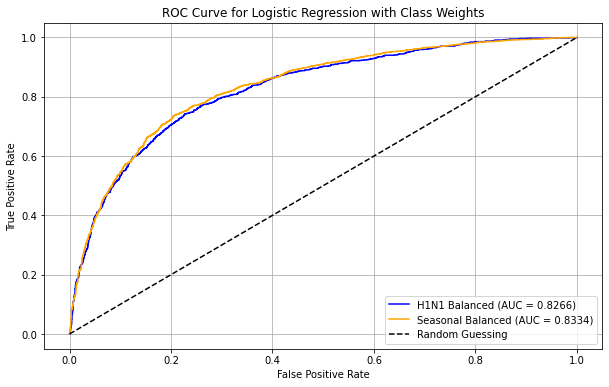

In [54]:
plt.figure(figsize=(10, 6))

# Plot ROC curve for H1N1 Logistic Regression with class weights
plt.plot(fpr_lr_balanced, tpr_lr_balanced, label=f'H1N1 Balanced (AUC = {auc_h1n1_lr_balanced:.4f})', color='blue')

# Plot ROC curve for Seasonal Logistic Regression with class weights
plt.plot(fpr_lr_seasonal_balanced, tpr_lr_seasonal_balanced, label=f'Seasonal Balanced (AUC = {auc_seasonal_lr_balanced:.4f})', color='orange')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with Class Weights')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()

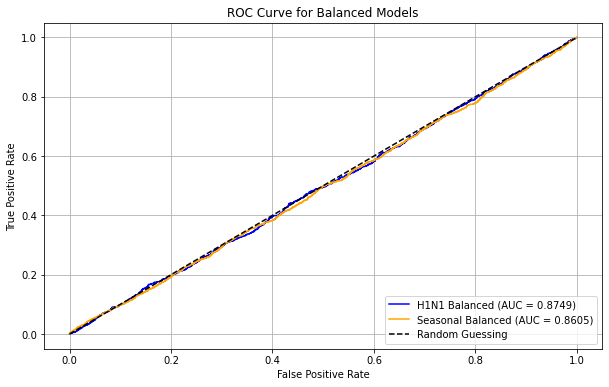

In [53]:
plt.figure(figsize=(10, 6))

# Plot ROC curve for H1N1 balanced model
plt.plot(fpr_lgbm_balanced, tpr_lgbm_balanced, label=f'H1N1 Balanced (AUC = {auc_h1n1_balanced:.4f})', color='blue')

# Plot ROC curve for Seasonal balanced model
plt.plot(fpr_lgbm_seasonal_balanced, tpr_lgbm_seasonal_balanced, label=f'Seasonal Balanced (AUC = {auc_seasonal_balanced:.4f})', color='orange')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Balanced Models')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()